# Model Development

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



Using TensorFlow backend.


In [134]:
df = df = pd.read_csv(project_path + '/data/raw/data.csv', index_col=0)
df.drop(['index', 'volumeto'], axis=1, inplace=True)
df.head()

,volumefrom,open,high,close,low,time
0,5308.04,6916.03,7032.79,7025.50,6890.13,1522486800
1,16533.51,7023.16,7198.68,7110.38,6984.43,1522490400
2,6133.92,7110.38,7144.87,7104.39,7062.55,1522494000
3,16748.27,7104.42,7228.40,7198.18,7067.62,1522497600
4,4564.56,7198.29,7198.80,7053.37,7051.17,1522501200


In [135]:
sample = df.iloc[20000:,:]


In [136]:
N_FEATURES = len(df.columns)
N_EPOCHS = 5
BATCH_SIZE = 128
INPUT_HOURS = 24
PREDICT_HOURS = 6


In [137]:
## Ripped from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [138]:
X = series_to_supervised(data=sample, n_in=INPUT_HOURS, n_out=PREDICT_HOURS)
X = X.iloc[:,:-(PREDICT_HOURS*N_FEATURES)]
X.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),...,var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
20024,2148.82,535.96,537.40,535.17,533.45,1.464854e+09,1177.86,535.17,537.94,536.75,...,465.43,463.91,462.68,1.450530e+09,2116.51,463.91,464.37,463.45,462.31,1.450534e+09
20025,1177.86,535.17,537.94,536.75,534.59,1.464858e+09,1328.83,536.75,538.57,536.78,...,464.37,463.45,462.31,1.450534e+09,1761.14,463.45,461.72,460.81,459.99,1.450537e+09
20026,1328.83,536.75,538.57,536.78,536.02,1.464862e+09,2055.16,536.78,537.51,536.31,...,461.72,460.81,459.99,1.450537e+09,11304.89,460.81,463.67,456.91,452.34,1.450541e+09
20027,2055.16,536.78,537.51,536.31,534.61,1.464865e+09,1865.92,536.31,536.62,534.38,...,463.67,456.91,452.34,1.450541e+09,5505.58,456.91,460.58,459.77,456.48,1.450544e+09
20028,1865.92,536.31,536.62,534.38,533.90,1.464869e+09,4380.38,534.38,535.58,532.19,...,460.58,459.77,456.48,1.450544e+09,3336.73,459.77,461.21,458.89,458.02,1.450548e+09


In [139]:
Y = series_to_supervised(data=list(sample['close']), n_in=INPUT_HOURS, n_out=PREDICT_HOURS)
Y.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
24,535.17,536.75,536.78,536.31,534.38,532.19,532.97,532.96,534.95,535.21,...,462.77,462.99,463.91,463.45,460.81,456.91,459.77,458.89,460.23,460.66
25,536.75,536.78,536.31,534.38,532.19,532.97,532.96,534.95,535.21,465.37,...,462.99,463.91,463.45,460.81,456.91,459.77,458.89,460.23,460.66,460.47
26,536.78,536.31,534.38,532.19,532.97,532.96,534.95,535.21,465.37,462.32,...,463.91,463.45,460.81,456.91,459.77,458.89,460.23,460.66,460.47,461.26
27,536.31,534.38,532.19,532.97,532.96,534.95,535.21,465.37,462.32,464.30,...,463.45,460.81,456.91,459.77,458.89,460.23,460.66,460.47,461.26,462.02
28,534.38,532.19,532.97,532.96,534.95,535.21,465.37,462.32,464.30,463.40,...,460.81,456.91,459.77,458.89,460.23,460.66,460.47,461.26,462.02,462.21


# train test split

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-PREDICT_HOURS:]
Y_test = Y_test.iloc[:,-PREDICT_HOURS:]

# preprocessing

In [141]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
def shape_model_data(data, n_features):
    model_data = data.reshape((data.shape[0], np.int(data.shape[1] / n_features), n_features))
    return model_data
X_train = shape_model_data(X_train, N_FEATURES)
X_test = shape_model_data(X_test, N_FEATURES)
X_train.shape

(24694, 24, 6)

In [143]:
def lstm_model(input_shape, num_outputs):
    model = Sequential()
    
    model.add(LSTM(64, input_shape=input_shape, activation='linear'))
    model.add(Dense(num_outputs, activation='linear'))
    
    return model


In [144]:
model = lstm_model(X_train.shape[1:], PREDICT_HOURS)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18176     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 18,566
Trainable params: 18,566
Non-trainable params: 0
_________________________________________________________________


In [145]:
from keras.optimizers import Adam
model.compile(loss='mae', optimizer=Adam(lr=0.0001))

fit = model.fit(X_train, Y_train, 
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test, Y_test))


Train on 24694 samples, validate on 1300 samples
Epoch 1/5
24694/24694 [==============================] - 14s 572us/step - loss: 299.5603 - val_loss: 117.2721
Epoch 2/5
24694/24694 [==============================] - 13s 541us/step - loss: 71.0244 - val_loss: 48.3960
Epoch 3/5
24694/24694 [==============================] - 14s 549us/step - loss: 43.8296 - val_loss: 39.9418
Epoch 4/5
24694/24694 [==============================] - 13s 545us/step - loss: 29.8033 - val_loss: 22.6860
Epoch 5/5
24694/24694 [==============================] - 14s 565us/step - loss: 21.7749 - val_loss: 22.2884


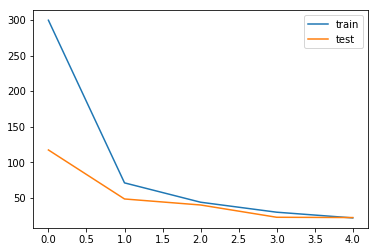

In [146]:
import matplotlib.pyplot as plt
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

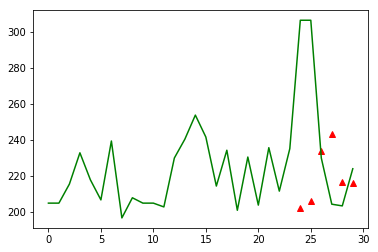

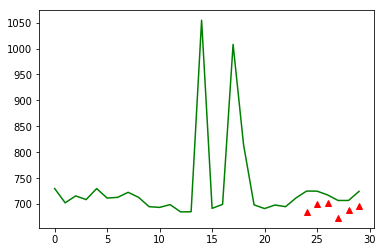

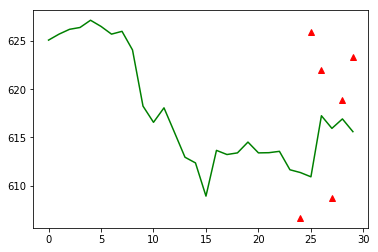

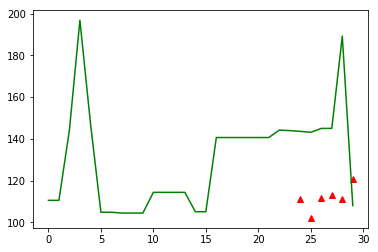

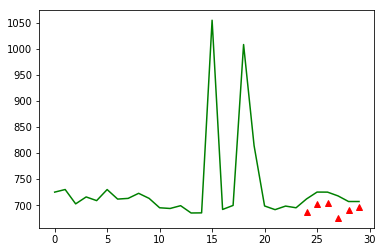

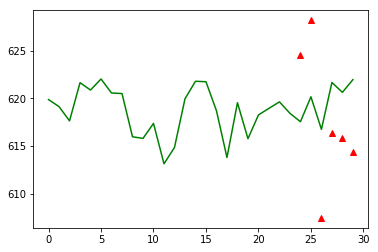

In [147]:

for ix in np.random.randint(0,Y_test_cache.shape[0],6):
    plt.figure()
    s = X_test[ix,:,:]
    predict = fit.model.predict(s.reshape(1, s.shape[0], s.shape[1])).reshape(6)
    actual = Y_test_cache.iloc[ix]
    plt.plot(range(24,30), predict, 'r^', range(30), actual, 'g-')